In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchattacks
import matplotlib.pyplot as plt

In [5]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28,1))
        label = self.data.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = CustomDataset(csv_file='mnist_train.csv', transform=transform)
test_dataset = CustomDataset(csv_file='mnist_test.csv', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [10]:
def train(model, train_loader, optimizer, criterion, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

train(model, train_loader, optimizer, criterion, device)


Epoch 1, Loss: 0.08072656393051147
Epoch 2, Loss: 0.05432514101266861
Epoch 3, Loss: 0.0424945130944252
Epoch 4, Loss: 0.0074187638238072395
Epoch 5, Loss: 0.016463503241539


In [11]:
def evaluate(model, test_loader, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

clean_accuracy = evaluate(model, test_loader, device)
print(f'Clean Test Accuracy: {clean_accuracy:.4f}')

Clean Test Accuracy: 0.9904


In [13]:
cw_attack = torchattacks.CW(model, c=1e-4, kappa=0, steps=100, lr=0.01)

def evaluate_adversarial_examples(model, test_loader, attack, device):
    correct = 0
    total = 0
    model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        adv_data = attack(data, target)
        with torch.no_grad():
            output = model(adv_data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

adversarial_accuracy = evaluate_adversarial_examples(model, test_loader, cw_attack, device)
print(f'Adversarial Test Accuracy: {adversarial_accuracy:.4f}')

Adversarial Test Accuracy: 0.9610


In [15]:
def adversarial_training(model, train_loader, optimizer, criterion, device, attack, epochs=5):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            adv_data = attack(data, target)
            optimizer.zero_grad()
            output = model(adv_data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Adversarial Training Loss: {loss.item()}")

# Perform adversarial training
adversarial_training(model, train_loader, optimizer, criterion, device, cw_attack, epochs=5)

# Evaluate the model after adversarial training
adversarial_trained_accuracy = evaluate_adversarial_examples(model, test_loader, cw_attack, device)
print(f'Adversarial Test Accuracy after Adversarial Training: {adversarial_trained_accuracy:.4f}')

Epoch 1, Adversarial Training Loss: 0.00021670489513780922
Epoch 2, Adversarial Training Loss: 0.006507406942546368
Epoch 3, Adversarial Training Loss: 0.00017546162416692823
Epoch 4, Adversarial Training Loss: 0.03489448130130768
Epoch 5, Adversarial Training Loss: 4.0783164877211675e-05
Adversarial Test Accuracy after Adversarial Training: 0.9832


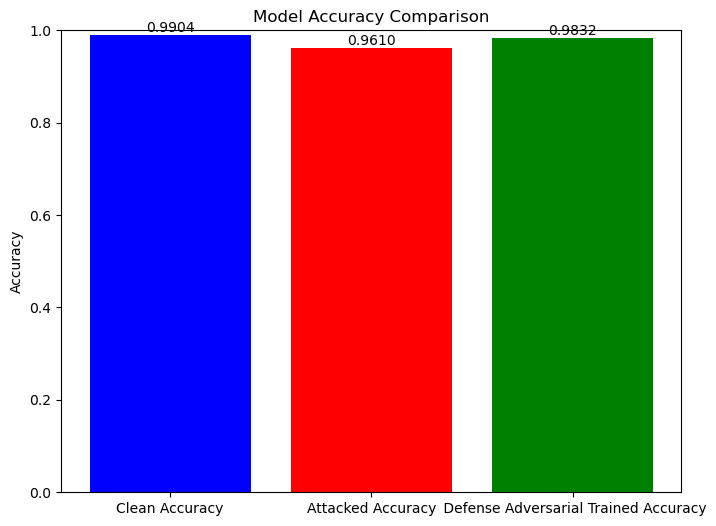

In [17]:
labels = ['Clean Accuracy', 'Attacked Accuracy', ' Defense Adversarial Trained Accuracy']
accuracies = [clean_accuracy, adversarial_accuracy, adversarial_trained_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'red', 'green'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
for i in range(len(labels)):
    plt.text(i, accuracies[i], f'{accuracies[i]:.4f}', ha='center', va='bottom')
plt.show()